<a href="https://colab.research.google.com/github/Polar-Tsai/Lesson_Record/blob/main/titanic_DataPreprocessing_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 摘要
使用kaggle上的「鐵達尼號倖存者」案例進行以下處理:
1. 資料預處理
2. 訓練模型 - 隨機森林
3. 訓練模型 - KNN

In [ ]:
from urllib.request import urlretrieve
url = "https://raw.githubusercontent.com/Elwing-Chou/ml0223/main/train.csv"
urlretrieve(url, "train.csv")
url = "https://raw.githubusercontent.com/Elwing-Chou/ml0223/main/test.csv"
urlretrieve(url, "test.csv")

('test.csv', <http.client.HTTPMessage at 0x7fd377335a90>)

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv", encoding = "utf-8")
test_df = pd.read_csv("test.csv", encoding = "utf-8")

In [ ]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### 資料預處理
1. 填補缺失(null)值: 補上最可能的值
* 類別行為的欄位: 選項固定(PClass, Name(mid), Sex, Cabin(1st), Embark)
>* 最常出現的數值補進去
* 數值類型: (Age, SibSp, Parch, Ticket(count有多少人共享同一個票根), Fare) 
>* XXXX取平均數補入? (以錢為單位)保險賠付
>* VVVV取中位數補入? (以人為單位)薪資


---

#### [Pandas.concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html)
>* 參數解釋
>>* axis = 0: df相接
>>* axis = 1: 擴充資料
>>* ignore_index: 將原本編號重新設定

In [ ]:
import pandas as pd
datas = pd.concat([train_df, test_df], axis = 0, ignore_index=True)
datas


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
s = datas.isna().sum() # 檢查是否為空值
# 篩選出特定值 Series[True/False] 
# 分類後可做升降冪
s[s > 0].sort_values(ascending = False)

Cabin       1014
Survived     418
Age          263
Embarked       2
Fare           1
dtype: int64

In [ ]:
# 丟掉資料
datas = datas.drop(["PassengerId", "Survived"], axis = 1)
datas

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
# 數值類型: 請補中位數
# 找出所有欄位的中位數
med = datas.median().drop("Pclass")
datas = datas.fillna(med) # 全部空值填入med

In [ ]:
# 類別類型: 補上最常出現
most = datas["Embarked"].value_counts().idxmax() # idxmax: 取出最大值
datas["Embarked"] = datas["Embarked"].fillna(most) # 設定回去

In [ ]:
# 檢查還有哪個欄位有空值
s = datas.isna().sum()
# 篩選出特定值 Series[True/False]
s[s > 0].sort_values(ascending = False)

Cabin    1014
dtype: int64

In [ ]:
# 處理Cabin缺失值
def cabin(s):
  if pd.isna(s): # 若為缺失值
    return None
  else:
    return s[0]
datas["Cabin"] = datas["Cabin"].apply(cabin) # 執行回去
datas["Cabin"]

0       None
1          C
2       None
3          C
4       None
        ... 
1304    None
1305       C
1306    None
1307    None
1308    None
Name: Cabin, Length: 1309, dtype: object

2. 類別要使用: One-Hot-Encoding
* >將選項化為0or1的是非問題
* >若空值被轉成OHE?(0,0,0)
* >不適合用在有大小關係的類別上(PClass)
* >可做選項:Name,Sex(可以不做但可以讓選擇呈開放式)、age，Parch

In [ ]:
# 萃取name中的稱謂
def name(s):
  mid = s.split(",")[-1].split(".")[0]
  mid = mid.strip() # 去除空白
  return mid
count = datas["Name"].apply(name).value_counts() # 計數並降冪
reserved = count[:4].index # 取前四名稱謂
def name2(s):
  mid = s.split(",")[-1].split(".")[0]
  mid = mid.strip() # 去除空白
  if mid in reserved:
    return mid
  else:
    return None
datas["Name"] = datas["Name"].apply(name2) # 執行回去
datas["Name"]

0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
         ...  
1304        Mr
1305      None
1306        Mr
1307        Mr
1308    Master
Name: Name, Length: 1309, dtype: object

In [ ]:
# 處理ticket
dic = datas["Ticket"].value_counts() # 檢查詳細資料
def ticket(t):
  return dic[t]
datas["Ticket"] = datas["Ticket"].apply(ticket)
datas["Ticket"]

0       1
1       2
2       1
3       2
4       1
       ..
1304    1
1305    3
1306    1
1307    1
1308    3
Name: Ticket, Length: 1309, dtype: int64

In [ ]:
datas

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,Mr,male,22.0,1,0,1,7.2500,None,S
1,1,Mrs,female,38.0,1,0,2,71.2833,C,C
2,3,Miss,female,26.0,0,0,1,7.9250,None,S
3,1,Mrs,female,35.0,1,0,2,53.1000,C,S
4,3,Mr,male,35.0,0,0,1,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...
1304,3,Mr,male,28.0,0,0,1,8.0500,None,S
1305,1,None,female,39.0,0,0,3,108.9000,C,C
1306,3,Mr,male,38.5,0,0,1,7.2500,None,S
1307,3,Mr,male,28.0,0,0,1,8.0500,None,S


In [ ]:
# 做OHE
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
datas = pd.get_dummies(datas)
datas = pd.get_dummies(datas, columns=["Pclass"]) # 針對Pclass特別設定OHE
datas

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,38.0,1,0,2,71.2833,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,26.0,0,0,1,7.9250,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,35.0,1,0,2,53.1000,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
4,35.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1305,39.0,0,0,3,108.9000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1306,38.5,0,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1307,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


##### 利用已知資料來增加新的選擇以提供演算法做抉擇
##### sibsp + parch = family


In [ ]:
datas["Family"] = datas["SibSp"] + datas["Parch"]
datas

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
0,22.0,1,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
1,38.0,1,0,2,71.2833,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
2,26.0,0,0,1,7.9250,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,35.0,1,0,2,53.1000,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1
4,35.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1305,39.0,0,0,3,108.9000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1306,38.5,0,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1307,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
# 將訓練資料、測試資料分出來
y = train_df["Survived"]
x = datas.iloc[:len(train_df)] # 取列: .iloc
predict = datas.iloc[len(train_df):]

### 隨機森林: 進階的決策樹
隨機放棄一點資料
>* Ensemble
>* 隨機森林的精髓：若在同一筆資料中，每個演算法都是採用所有資料分析，結果是大同小異；故，應該要隨機放棄部分資料，才能有不一樣的結果
### [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
>* 須留意參數
>>* n_estimators: 範圍10-200
>>* max_dapth


---


### 調整參數守則
### Cross Validational(交叉驗證)
>* 適用於大多演算法
>*將資料切成10分
>* 第一次訓練拿1-9，測試拿第10分
>* 第二次訓練拿1-8 and 10，測試拿第9分
>*依此類推後，把結果做比較

In [ ]:
# 先用GridSearch粗估
from sklearn.ensemble import RandomForestClassifier
# Grid Search(設定迴圈讓程式自己跑出多組結果)
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
params = {
    "n_estimators":range(11, 151, 2), # 從11-151間取奇數棵
    "max_depth":range(3, 11) # 隨意取個區間
}
grid = GridSearchCV(clf, params, cv=10, n_jobs=-1, scoring="neg_log_loss")
grid.fit(x, y)
print(grid.best_score_)
print(grid.best_params_)


-0.39783672500174755
{'max_depth': 7, 'n_estimators': 141}


In [ ]:
# 再利用交叉驗證微調最後的參數
import numpy as np # 常用在資料多時來分析
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(n_estimators=29, max_depth=6)
scores = cross_val_score(clf, x, y, cv=10, n_jobs=-1)
# 參數必填: estimator, x, y, cv(切幾分), n_jobs(-1依CPU顆數設定)
print(scores) # 有10筆分數
print(np.average(scores)) # 平均分數
# 呈現accuracy的資料，以正值呈現，越大越好(越近100%越棒)
# r2_score也是一樣邏輯

# 轉換成loss。
clf = RandomForestClassifier(n_estimators=29, max_depth=6)
scores = cross_val_score(clf, x, y, cv=10, n_jobs=-1, scoring="neg_log_loss")
# neg_log_loss: 目標為取得最小loss，在neg使用時，越靠近0(整體在負數情況下越大越好)越好
# 交叉驗證、classification

# 參數必填: estimator, X, y, cv(切幾分), n_jobs(-1依CPU顆數設定)
print(scores) # 與正確答案的誤差值
print(np.average(scores)) # 越接近0(答案)越好

[0.82222222 0.86516854 0.76404494 0.8988764  0.86516854 0.83146067
 0.84269663 0.7752809  0.86516854 0.83146067]
0.8361548064918851
[-0.47691288 -0.38296278 -0.58482725 -0.357844   -0.34522152 -0.41490029
 -0.39964795 -0.43157358 -0.3303892  -0.36963731]
-0.40939167744947547


#### log_loss(crossentropy)的使用小結論: 
> 和準確度有關，log_loss是越大越好

> 和偏移有關(計算跟正解的距離)，log_loss是越小越好

In [ ]:
# 將最後結果存成檔案

clf = RandomForestClassifier(n_estimators=29, max_depth=6)
clf.fit(x,y)
pre = clf.predict(predict)
ans = pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":pre
})
ans.to_csv("rf.csv", encoding="utf-8", index=False)

In [ ]:
# 觀察係數的重視度
import pandas as pd
pd.DataFrame(clf.feature_importances_, 
       columns=["Importance"],
       index=datas.columns).sort_values(by="Importance", ascending=False)

,Importance
Sex_female,0.206702
Sex_male,0.203191
Fare,0.084516
Name_Mr,0.076331
Pclass_3,0.060752
Age,0.059211
Family,0.047469
Ticket,0.046317
Pclass_1,0.044266
Name_Master,0.029484


In [ ]:
dt = clf.estimators_[0]
dt
# 觀察決策樹

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=324708556, splitter='best')

[Text(390.6, 665.91, 'Sex_male <= 0.5\ngini = 0.476\nsamples = 553\nvalue = [543, 348]\nclass = Dead'),
 Text(195.3, 475.65, 'Pclass_3 <= 0.5\ngini = 0.372\nsamples = 188\nvalue = [74, 226]\nclass = Alive'),
 Text(97.65, 285.39, 'Fare <= 22.0\ngini = 0.08\nsamples = 103\nvalue = [7, 160]\nclass = Alive'),
 Text(48.825, 95.13, '\n  (...)  \n'),
 Text(146.47500000000002, 95.13, '\n  (...)  \n'),
 Text(292.95000000000005, 285.39, 'Parch <= 1.5\ngini = 0.5\nsamples = 85\nvalue = [67, 66]\nclass = Dead'),
 Text(244.125, 95.13, '\n  (...)  \n'),
 Text(341.77500000000003, 95.13, '\n  (...)  \n'),
 Text(585.9000000000001, 475.65, 'Ticket <= 1.5\ngini = 0.328\nsamples = 365\nvalue = [469, 122]\nclass = Dead'),
 Text(488.25, 285.39, 'Age <= 77.0\ngini = 0.256\nsamples = 231\nvalue = [310, 55]\nclass = Dead'),
 Text(439.425, 95.13, '\n  (...)  \n'),
 Text(537.075, 95.13, '\n  (...)  \n'),
 Text(683.5500000000001, 285.39, 'Family <= 3.5\ngini = 0.417\nsamples = 134\nvalue = [159, 67]\nclass = Dead

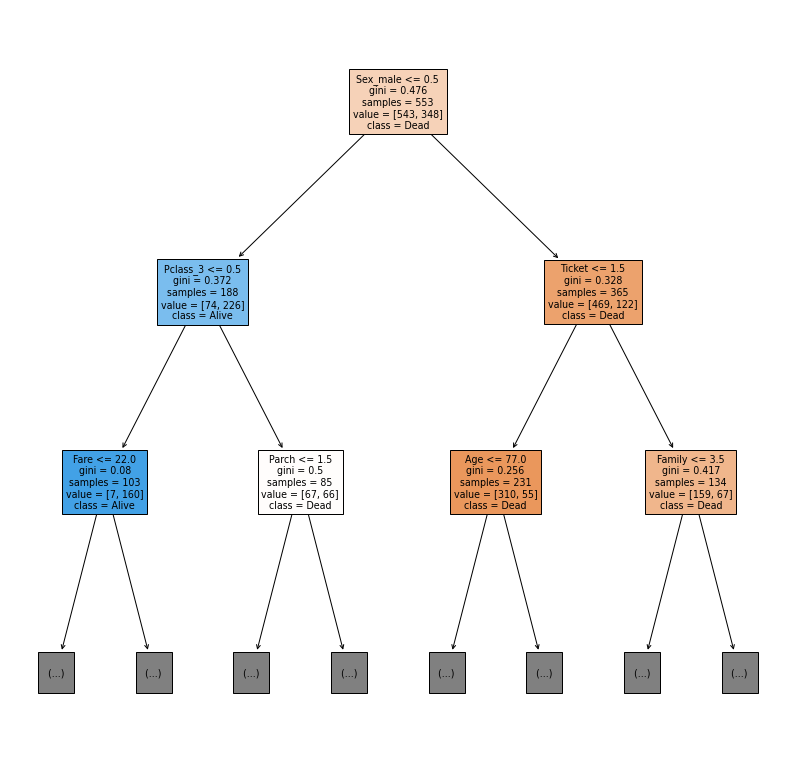

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
dt = clf.estimators_[1]
plt.figure(figsize=(14, 14))
plot_tree(dt, 
     feature_names=datas.columns, 
     class_names=["Dead", "Alive"],
     max_depth=2, 
     filled=True)

畫圖: 最後處理 了解最後結果

須留意作圖的調整參數:
* title: 標題
* axis: 圖的大小
* ticks: 刻度
* legend: 


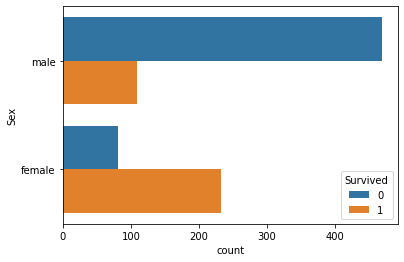

In [ ]:
import seaborn as sns
sns.countplot(y=train_df["Sex"], hue=train_df["Survived"])

Text(0.5, 1.0, 'Fare Plot')

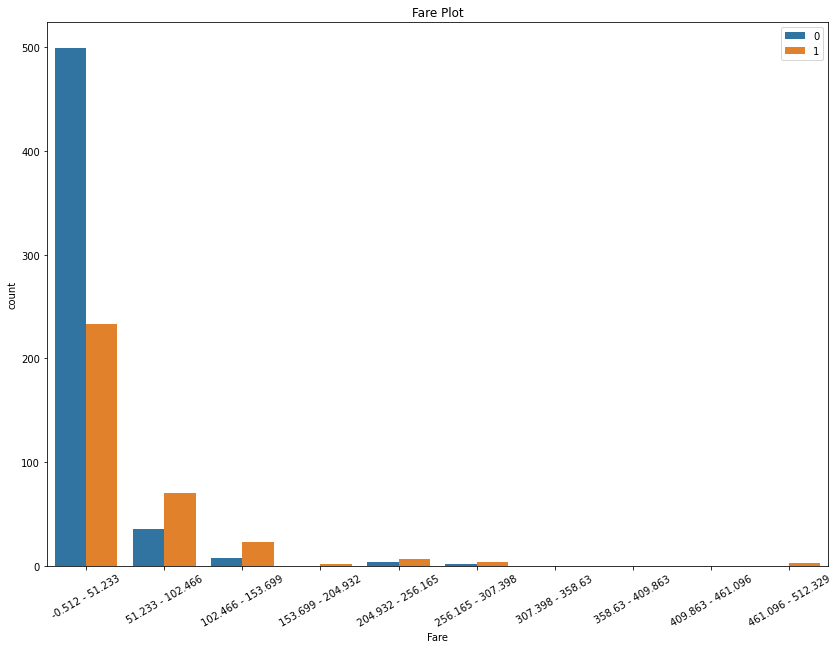

In [ ]:
c = pd.cut(train_df["Fare"], bins=10)
def beautify(s):
    return str(s)[1:-1].replace(", ", " - ")
b = c.apply(beautify)
plt.figure(figsize=(14, 10))
sns.countplot(x=b, hue=train_df["Survived"])
plt.xticks(rotation=30)
plt.legend(loc='upper right')
plt.title("Fare Plot")

Text(0.5, 1.0, 'Fare Plot')

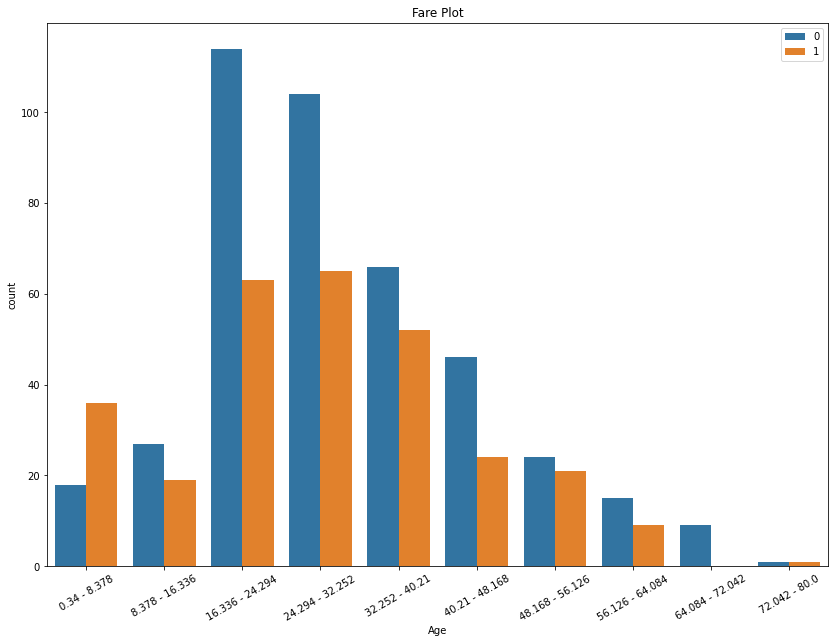

In [ ]:
c = pd.cut(train_df["Age"], bins=10)
def beautify(s):
    return str(s)[1:-1].replace(", ", " - ")
b = c.apply(beautify)
plt.figure(figsize=(14, 10))
sns.countplot(x=b, hue=train_df["Survived"])
plt.xticks(rotation=30)
plt.legend(loc='upper right')
plt.title("Fare Plot")

###KNN(K-Nearest Neighbors)
####找最近的K個點，觀察哪個結果多就取哪個結果
####scaling: 為了避免因單位導致數字差太多，須把數字轉換成0-1區間


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
datas_scale = scaler.fit_transform(datas)
datas_scale = pd.DataFrame(datas_scale, columns=datas.columns)
datas_scale

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
0,0.273456,0.125,0.000000,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.1
1,0.473882,0.125,0.000000,0.1,0.139136,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.1
2,0.323563,0.000,0.000000,0.0,0.015469,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.436302,0.125,0.000000,0.1,0.103644,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.1
4,0.436302,0.000,0.000000,0.0,0.015713,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.348616,0.000,0.000000,0.0,0.015713,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1305,0.486409,0.000,0.000000,0.2,0.212559,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1306,0.480145,0.000,0.000000,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1307,0.348616,0.000,0.000000,0.0,0.015713,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
x_scale = datas.iloc[:len(train_df)] # 取列: .iloc
predict_scale = datas.iloc[len(train_df):]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
clf = KNeighborsClassifier()
params = {
    "n_neighbors":range(5, 200),
}
grid = GridSearchCV(clf, params, cv=10, n_jobs=-1, scoring="neg_log_loss")
grid.fit(x_scale, y)
print(grid.best_score_)
print(grid.best_params_)

-0.5714870131173362
{'n_neighbors': 35}


In [ ]:
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(x_scale, y)
pre = clf.predict(predict_scale)
ans = pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":pre
})
ans.to_csv("knn.csv", encoding="utf-8", index=False)

### 隨機森林 v.s. KNN

1. 資料量
>* Random Forest: 抓全部資料
>>* 資料多時好用
>* KNN: K附近的x點
>>* 資料少時好用 
2. 調整參數
>* Random Forest: 困難，需要重複嘗試
>* KNN: 穩定
3. **特徵的係數(重視程度)**
>* Random Forest: **有!!!!很高!!!** (會挑選高度正相關的係數掉)
>* KNN: **沒有啦!!!!所有係數都一視同仁** (重複計算在4次以內是可以忍受的)

### 線性相關係數
>* 斜率(m)< 1: 完全負相關
>* m> 1:  完全正相關
>* 無法計算m: 0相關